# Embeddings for categorical features

In [67]:
from utilities.std_imports import *
from utilities.tf_imports import *
from sklearn.model_selection import train_test_split

### Load data

In [80]:
ds = pd.read_csv(csv_path + 'time_series/store_dmdfcst_train.csv', parse_dates=True, index_col = 0)
ds.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


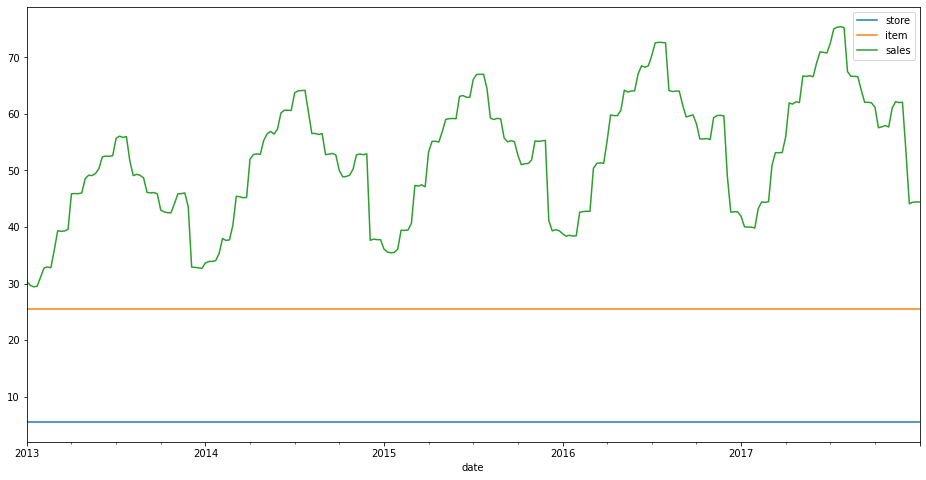

In [81]:
ds.groupby('date').mean().resample('w').mean().plot(figsize=[16,8]);

### Prepare data

In [82]:
ds.drop('sales', 1, inplace=True)
ds['y'] = ds.index.year-ds.index.year.min()
ds['m'] = ds.index.month
ds['d'] = ds.index.day
ds['dow'] = ds.index.dayofweek
ds.head()

,store,item,y,m,d,dow
date,,,,,,
2013-01-01,1,1,0,1,1,1
2013-01-02,1,1,0,1,2,2
2013-01-03,1,1,0,1,3,3
2013-01-04,1,1,0,1,4,4
2013-01-05,1,1,0,1,5,5


In [84]:
y = ds['y']
X = ds.drop('y', axis=1)

cat_vars = list(ds.columns)
cat_vars.remove('y')
cont_vars = ['y']

In [85]:
x_train, x_test, y_train, y_test = train_test_split(X, ds['y'], test_size=.1, random_state=0, shuffle = True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((821700, 5), (91300, 5), (821700,), (91300,))

In [ ]:
X_train = []
X_test = []
X_train.append(x_train[cont_vars].astype('float32').values)
X_test.append(x_test[cont_vars].astype('float32').values)
for cat in cat_vars:
    X_train.append(x_train[cat].values)
    X_test.append(x_test[cat].values)

### Embeddings

In [ ]:
cat_sizes = {}
cat_embsizes = {}
for cat in cat_vars:
    cat_sizes[cat] = train_data[cat].nunique()
    cat_embsizes[cat] = min(50, cat_sizes[cat]//2+1)

### Build model

In [66]:
def custom_smape(x, x_):
    return tkb.mean(2 * tkb.abs(x-x_) / (tkb.abs(x) + tkb.abs(x_)))

In [ ]:
ins = []
concat = []

for cat in cat_vars:
    x = Input((1,), name=cat)
    ins.append(x)
    x = Embedding(cat_sizes[cat]+1, cat_embsizes[cat], input_length=1)(x)
    x = Reshape((cat_embsizes[cat],))(x)
    concat.append(x)

In [ ]:
y = Input((len(cont_vars),), name='cont_vars')
ins.append(y)
concat.append(y)

y = tkl.Concatenate()(concat)
y = tkl.Dense(100, activation= 'relu')(y)
y = tkl.Dense(1)(y)
model = tkm.Model(ins, y)
model.compile('adam', custom_smape)

In [ ]:
model.fit(X_train, y_train, 64, 3, validation_data=[X_test, y_test])

### Prediction

In [ ]:
pred = model.predict(X_test)
pred

### Credits & Links

https://medium.com/@davidheffernan_99410/an-introduction-to-using-categorical-embeddings-ee686ed7e7f9